# IMPORT LIBRARIES

In [84]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
import nltk
from math import sqrt

# Downloading, merging and preprocessing non financial dataset.

In [85]:
def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        df = df['Close'].rename(ticker)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.Series(name=ticker)

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=20*365)).strftime('%Y-%m-%d')

tickers = ['FRSH', 'NEM', 'XOM', 'INR=X']

dataframes = [download_data(ticker, start_date, end_date) for ticker in tickers]

merged_data = pd.concat(dataframes, axis=1).dropna()
merged_data.columns = ['FRESHWORKS', 'GOLD', 'PETROL', 'CURRENCY']

merged_data.to_csv('merged_data.csv')

if merged_data.isna().any().any():
    print("Warning: NaN values present in the merged data.")
else:
    print("Data downloaded and merged successfully.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data downloaded and merged successfully.


In [86]:
data = pd.read_csv('merged_data.csv')
df = data

In [87]:
data

,Date,FRESHWORKS,GOLD,PETROL,CURRENCY
0,2021-09-22,47.549999,54.650002,55.209999,73.792702
1,2021-09-23,47.540001,54.049999,57.080002,73.874901
2,2021-09-24,46.750000,53.869999,57.590000,73.839996
3,2021-09-27,44.049999,53.900002,59.299999,73.812897
4,2021-09-28,42.730000,54.580002,59.919998,73.825302
...,...,...,...,...,...
646,2024-04-18,17.650000,38.549999,118.519997,83.595802
647,2024-04-19,17.590000,39.020000,119.879997,83.544998
648,2024-04-22,18.160000,37.459999,120.559998,83.385300
649,2024-04-23,18.350000,37.709999,121.029999,83.386200


In [88]:
data.dtypes

Date           object
FRESHWORKS    float64
GOLD          float64
PETROL        float64
CURRENCY      float64
dtype: object

In [89]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)
datetime_object = str_to_datetime('2020-01-01')
datetime_object

datetime.datetime(2020, 1, 1, 0, 0)

In [90]:
data['Date'] = data['Date'].apply(str_to_datetime)
data['Date']

0     2021-09-22
1     2021-09-23
2     2021-09-24
3     2021-09-27
4     2021-09-28
         ...    
646   2024-04-18
647   2024-04-19
648   2024-04-22
649   2024-04-23
650   2024-04-24
Name: Date, Length: 651, dtype: datetime64[ns]

In [91]:
data.index = data.pop('Date')
data

,FRESHWORKS,GOLD,PETROL,CURRENCY
Date,,,,
2021-09-22,47.549999,54.650002,55.209999,73.792702
2021-09-23,47.540001,54.049999,57.080002,73.874901
2021-09-24,46.750000,53.869999,57.590000,73.839996
2021-09-27,44.049999,53.900002,59.299999,73.812897
2021-09-28,42.730000,54.580002,59.919998,73.825302
...,...,...,...,...
2024-04-18,17.650000,38.549999,118.519997,83.595802
2024-04-19,17.590000,39.020000,119.879997,83.544998
2024-04-22,18.160000,37.459999,120.559998,83.385300


In [92]:
data.shape

(651, 4)

In [93]:
data.describe()

,FRESHWORKS,GOLD,PETROL,CURRENCY
count,651.000000,651.000000,651.000000,651.000000
mean,19.349094,49.146574,96.942212,80.265054
std,7.348342,12.059032,16.778709,3.218833
min,10.880000,29.860001,55.209999,73.792702
25%,14.725000,40.390001,86.600002,77.395401
50%,17.620001,45.299999,102.739998,81.975502
75%,21.040001,56.385000,109.150002,82.869949
max,50.250000,85.419998,122.199997,85.194000


In [94]:
print(data.isnull().sum())

FRESHWORKS    0
GOLD          0
PETROL        0
CURRENCY      0
dtype: int64


In [95]:
data.dropna(inplace=True)

In [96]:
print(data.isnull().sum())

FRESHWORKS    0
GOLD          0
PETROL        0
CURRENCY      0
dtype: int64


In [97]:
data.shape

(651, 4)

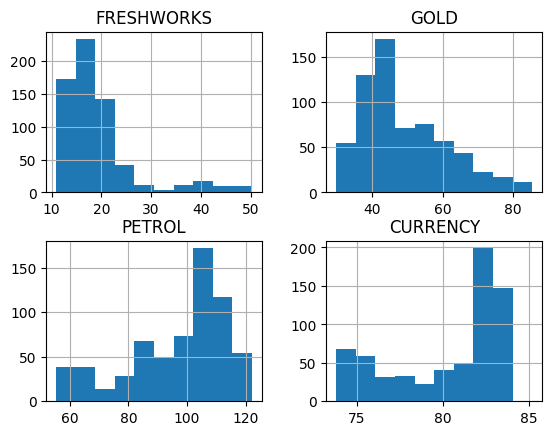

In [98]:
data.hist()
plt.show()

In [99]:
print(data.corr())

            FRESHWORKS      GOLD    PETROL  CURRENCY
FRESHWORKS    1.000000  0.122233 -0.652857 -0.516393
GOLD          0.122233  1.000000 -0.592337 -0.807103
PETROL       -0.652857 -0.592337  1.000000  0.899275
CURRENCY     -0.516393 -0.807103  0.899275  1.000000


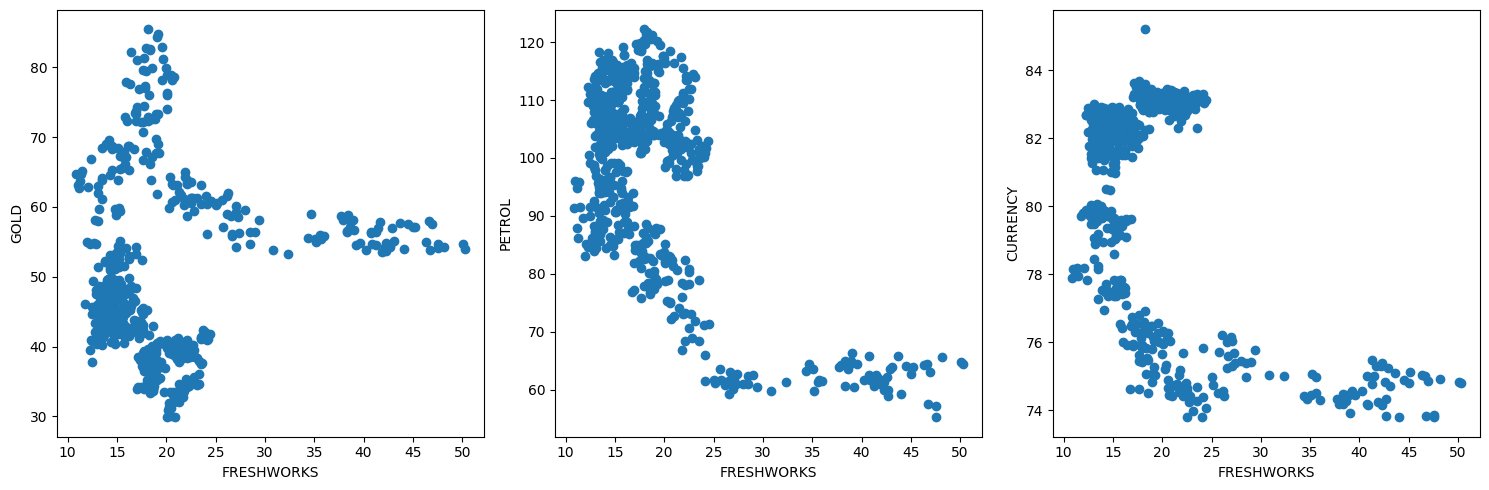

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(['GOLD', 'PETROL', 'CURRENCY']):
    axs[i].scatter(data['FRESHWORKS'], data[col])
    axs[i].set_xlabel('FRESHWORKS')
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()


# Linear Regression

c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Actual vs. Predicted Values:
            Actual RELIANCE  Predicted RELIANCE
Date                                           
2024-04-08        18.639999           13.892090
2022-10-10        12.850000           18.534144
2022-10-03        13.900000           21.332562
2023-09-12        21.680000           15.323709
2022-01-04        24.100000           30.125485
...                     ...                 ...
2023-10-05        18.820000           17.694972
2023-07-11        17.090000           16.812395
2022-11-29        14.050000           15.873959
2023-10-25        17.709999           18.230992
2023-01-20        15.000000           12.669595

[131 rows x 2 columns]

Mean Squared Error (MSE): 24.504440044907536
Root Mean Squared Error (RMSE): 4.950195960253244
Mean Absolute Error (MAE): 3.910086356421153


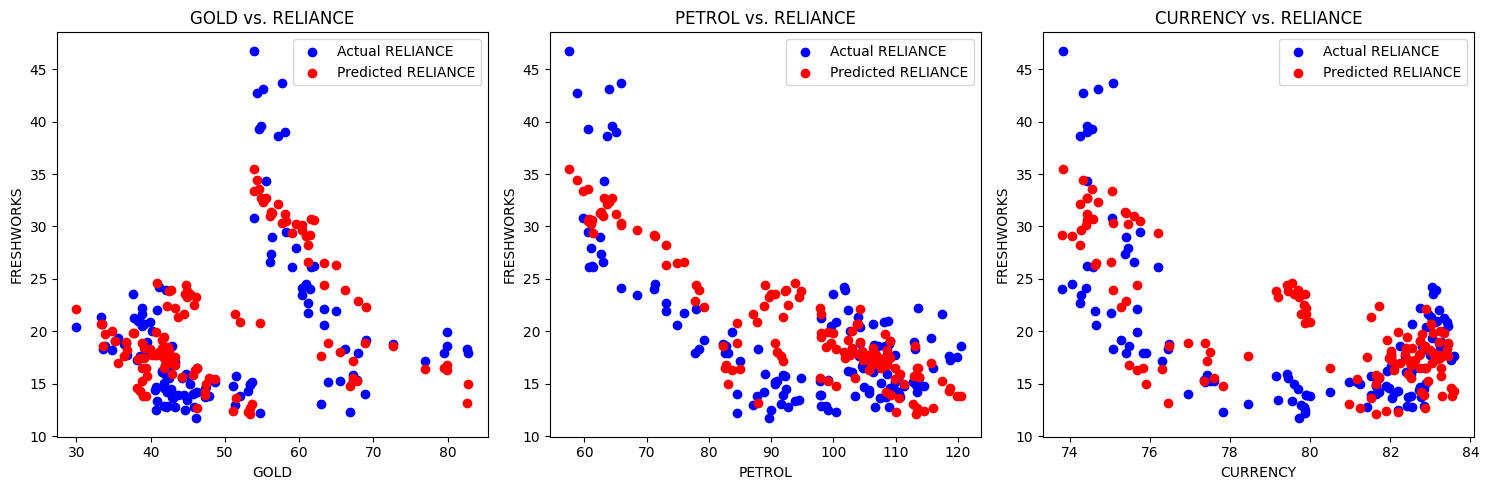

In [101]:
# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Display actual and predicted values in a table
results_table = pd.DataFrame({
    'Actual RELIANCE': y_test,
    'Predicted RELIANCE': y_pred
})

print("Actual vs. Predicted Values:")
print(results_table)

# Display evaluation metrics
print(f'\nMean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot scatter plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].scatter(X_test['GOLD'], y_test, color='blue', label='Actual RELIANCE')
axes[0].scatter(X_test['GOLD'], y_pred, color='red', label='Predicted RELIANCE')
axes[0].set_xlabel('GOLD')
axes[0].set_ylabel('FRESHWORKS')
axes[0].set_title('GOLD vs. RELIANCE')
axes[0].legend()

axes[1].scatter(X_test['PETROL'], y_test, color='blue', label='Actual RELIANCE')
axes[1].scatter(X_test['PETROL'], y_pred, color='red', label='Predicted RELIANCE')
axes[1].set_xlabel('PETROL')
axes[1].set_ylabel('FRESHWORKS')
axes[1].set_title('PETROL vs. RELIANCE')
axes[1].legend()

axes[2].scatter(X_test['CURRENCY'], y_test, color='blue', label='Actual RELIANCE')
axes[2].scatter(X_test['CURRENCY'], y_pred, color='red', label='Predicted RELIANCE')
axes[2].set_xlabel('CURRENCY')
axes[2].set_ylabel('FRESHWORKS')
axes[2].set_title('CURRENCY vs. RELIANCE')
axes[2].legend()

plt.tight_layout()
plt.show()


In [102]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

metrics_dict = {'GOLD': {}, 'PETROL': {}, 'CURRENCY': {}}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict[feature]['MSE'] = mse
    metrics_dict[feature]['RMSE'] = rmse
    metrics_dict[feature]['R-squared'] = r2

for feature, metrics in metrics_dict.items():
    print(f'Feature: {feature}')
    print(f'Mean Squared Error: {metrics["MSE"]}')
    print(f'Root Mean Squared Error: {metrics["RMSE"]}')
    print(f'R-squared: {metrics["R-squared"]}')
    print('-' * 30)


Feature: GOLD
Mean Squared Error: 49.37727747193656
Root Mean Squared Error: 7.026896717039219
R-squared: 0.029547834650243132
------------------------------
Feature: PETROL
Mean Squared Error: 28.582026208613307
Root Mean Squared Error: 5.34621606452763
R-squared: 0.4382539774495099
------------------------------
Feature: CURRENCY
Mean Squared Error: 35.47154490746548
Root Mean Squared Error: 5.955799266888154
R-squared: 0.30284861121969553
------------------------------


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [103]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

metrics_dict = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict['Feature'].append(feature)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['R-squared'].append(r2)

results_df = pd.DataFrame(metrics_dict)
print(results_df)


    Feature        MSE      RMSE  R-squared
0      GOLD  49.377277  7.026897   0.029548
1    PETROL  28.582026  5.346216   0.438254
2  CURRENCY  35.471545  5.955799   0.302849


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Random Forest

In [104]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

metrics_dict_rf = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X_train, y_train)

    y_pred_rf = model_rf.predict(X_test)

    mse_rf, rmse_rf, r2_rf = calculate_metrics(y_test, y_pred_rf)

    metrics_dict_rf['Feature'].append(feature)
    metrics_dict_rf['MSE'].append(mse_rf)
    metrics_dict_rf['RMSE'].append(rmse_rf)
    metrics_dict_rf['R-squared'].append(r2_rf)

results_df_rf = pd.DataFrame(metrics_dict_rf)
print(results_df_rf)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


    Feature        MSE      RMSE  R-squared
0      GOLD  34.517854  5.875190   0.321592
1    PETROL  18.503808  4.301605   0.636329
2  CURRENCY  33.179945  5.760204   0.347887


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# KNN

In [105]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(X_train, y_train)

    y_pred_knn = model_knn.predict(X_test)

    mse_knn, rmse_knn, r2_knn = calculate_metrics(y_test, y_pred_knn)

    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['R-squared'].append(r2_knn)

results_df_knn = pd.DataFrame(metrics_dict_knn)
print(results_df_knn)


    Feature        MSE      RMSE  R-squared
0      GOLD  25.026064  5.002606   0.508142
1    PETROL  14.758815  3.841720   0.709933
2  CURRENCY  25.496866  5.049442   0.498889


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# ANN

In [106]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))

model_ann.compile(optimizer='adam', loss='mean_squared_error')

model_ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_ann = model_ann.predict(X_test_scaled).flatten()

mse_ann, rmse_ann, r2_ann = calculate_metrics(y_test, y_pred_ann)

# Create a DataFrame to display actual and predicted prices
results_ann = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices (ANN)': y_pred_ann})

# Display the DataFrame and metrics
print("Actual and Predicted Prices (ANN):")
print(results_ann.head())

print("\nPerformance Metrics (ANN):")
print(f'Mean Squared Error (ANN): {mse_ann}')
print(f'Root Mean Squared Error (ANN): {rmse_ann}')
print(f'R-squared (ANN): {r2_ann}')


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Actual and Predicted Prices (ANN):
            Actual Prices  Predicted Prices (ANN)
Date                                             
2024-04-08      18.639999               20.393166
2022-10-10      12.850000               16.804665
2022-10-03      13.900000               15.739904
2023-09-12      21.680000               19.235739
2022-01-04      24.100000               33.177582

Performance Metrics (ANN):
Mean Squared Error (ANN): 12.87451190686465
Root Mean Squared Error (ANN): 3.5881070088369227
R-squared (ANN): 0.7469666494889473


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# LSTM

Epoch 1/50


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0369 - val_loss: 0.0050
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 9.3242e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 9.1435e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 9.0209e-04
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_

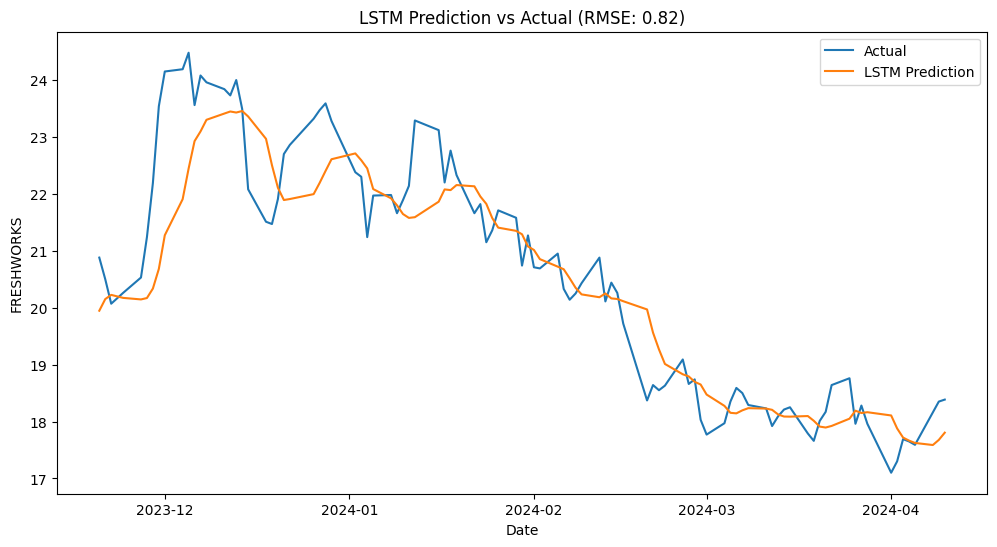

Root Mean Squared Error (RMSE): 0.82
Error Percentage: 3.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecasted stock prices for the upcoming 7 days:
2024-04-25: 19.946693420410156
2024-04-26: 20.15115737915039
2024-04-27: 20.224895477294922
2024-04-28: 20.17215919494629
2024-04-29: 20.145170211791992
2024-04-30: 20.169443130493164


In [107]:
target_variable = 'FRESHWORKS'
y = data[target_variable].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10

X_seq, y_seq = create_sequences(y_scaled, sequence_length)

train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)
test_size = len(X_seq) - train_size - val_size

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

test_dates = data.index[train_size+val_size : train_size+val_size+len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Prediction')
plt.title(f'LSTM Prediction vs Actual (RMSE: {rmse_lstm:.2f})')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.legend()
plt.show()

error_percentage = (rmse_lstm / np.mean(y_test_inv)) * 100

print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.2f}')
print(f'Error Percentage: {error_percentage:.2f}%')

forecasted_values_scaled = []
for i in range(7):
    X_new = np.array([X_test[i]])
    forecasted_value_scaled = model_lstm.predict(X_new)[0][0]
    forecasted_values_scaled.append(forecasted_value_scaled)
    X_test = np.concatenate((X_test, X_new), axis=0)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))
forecasted_dates = pd.date_range(data.index[-1], periods=7, freq='D')[1:]

print("Forecasted stock prices for the upcoming 7 days:")
for date, price in zip(forecasted_dates, forecasted_values):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")




# All models together

In [108]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_ann = StandardScaler()
X_train_scaled_ann = scaler_ann.fit_transform(X_train)
X_test_scaled_ann = scaler_ann.transform(X_test)
X_val_scaled_ann = scaler_ann.transform(X_val)

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_lstm = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled_lstm = scaler_lstm.transform(y_test.values.reshape(-1, 1))

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr, rmse_lr, mae_lr = calculate_metrics(y_test, y_pred_lr)
error_percentage_lr = (mae_lr / y_test.mean()) * 100

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf, rmse_rf, mae_rf = calculate_metrics(y_test, y_pred_rf)
error_percentage_rf = (mae_rf / y_test.mean()) * 100

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'MAE': []}
for feature in X.columns:
    current_feature = X_train[[feature]]
    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(current_feature, y_train)
    current_feature_test = X_test[[feature]]
    y_pred_knn = model_knn.predict(current_feature_test)
    mse_knn, rmse_knn, mae_knn = calculate_metrics(y_test, y_pred_knn)
    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['MAE'].append(mae_knn)

metrics_df_knn = pd.DataFrame(metrics_dict_knn)
error_percentage_knn = (metrics_df_knn['MAE'].mean() / y_test.mean()) * 100

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))
model_ann.compile(optimizer='adam', loss='mean_squared_error')
model_ann.fit(X_train_scaled_ann, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_ann = model_ann.predict(X_test_scaled_ann).flatten()
mse_ann, rmse_ann, mae_ann = calculate_metrics(y_test, y_pred_ann)
error_percentage_ann = (mae_ann / y_test.mean()) * 100

sequence_length_lstm = 10
X_seq_lstm, y_seq_lstm = create_sequences(y_train_scaled_lstm, sequence_length_lstm)

X_seq_val_lstm, y_seq_val_lstm = create_sequences(scaler_lstm.transform(y_val.values.reshape(-1, 1)), sequence_length_lstm)
X_seq_test_lstm, y_seq_test_lstm = create_sequences(y_test_scaled_lstm, sequence_length_lstm)

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_seq_lstm.shape[1], X_seq_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_lstm, y_seq_lstm, epochs=50, batch_size=32, validation_data=(X_seq_val_lstm, y_seq_val_lstm), verbose=0)
y_pred_lstm = model_lstm.predict(X_seq_test_lstm)
y_pred_lstm_inv = scaler_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv_lstm = scaler_lstm.inverse_transform(y_seq_test_lstm.reshape(-1, 1)).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv))

results_lr = pd.DataFrame({'Actual': y_test, 'Predicted_LR': y_pred_lr})
results_rf = pd.DataFrame({'Actual': y_test, 'Predicted_RF': y_pred_rf})
results_knn = pd.DataFrame({'Actual': y_test, 'Predicted_KNN': y_pred_knn})
results_ann = pd.DataFrame({'Actual': y_test, 'Predicted_ANN': y_pred_ann})
results_lstm = pd.DataFrame({'Actual': y_test_inv_lstm, 'Predicted_LSTM': y_pred_lstm_inv})

error_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'k-Nearest Neighbors', 'Artificial Neural Network', 'LSTM'],
    'MSE': [mse_lr, mse_rf, metrics_df_knn['MSE'].mean(), mse_ann, mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'RMSE': [rmse_lr, rmse_rf, metrics_df_knn['RMSE'].mean(), rmse_ann, rmse_lstm],
    'MAE': [mae_lr, mae_rf, metrics_df_knn['MAE'].mean(), mae_ann, mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'Error Percentage': [error_percentage_lr, error_percentage_rf, error_percentage_knn, error_percentage_ann, (mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv) / y_test_inv_lstm.mean()) * 100]
})

print("Results for Linear Regression:")
print(results_lr.head())
print("\nResults for Random Forest:")
print(results_rf.head())
print("\nResults for k-Nearest Neighbors:")
print(results_knn.head())
print("\nResults for Artificial Neural Network:")
print(results_ann.head())
print("\nResults for LSTM:")
print(results_lstm.head())

print("\nError Table:")
print(error_df)

error_df.to_csv('regression_results.csv', index=False)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squ

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Results for Linear Regression:
               Actual  Predicted_LR
Date                               
2022-07-22  13.030000     21.362498
2021-11-26  35.549999     31.912081
2023-08-08  21.450001     17.300507
2022-07-05  14.770000     19.728585
2023-05-31  15.760000     18.467860

Results for Random Forest:
               Actual  Predicted_RF
Date                               
2022-07-22  13.030000       13.4174
2021-11-26  35.549999       36.7022
2023-08-08  21.450001       20.3830
2022-07-05  14.770000       13.7795
2023-05-31  15.760000       17.8392

Results for k-Nearest Neighbors:
               Actual  Predicted_KNN
Date                                
2022-07-22  13.030000         13.344
2021-11-26  35.549999         27.980
2023-08-08  21.450001         17.140
2022-07-05  14.770000         14.284
2023-05-31  15.760000         15.208

Results for Artificial Neural Network:
               Actual  Predicted_ANN
Date                         

# SENTIMENT ANALYSIS

In [109]:
import finnhub
import csv
import datetime
import yfinance as yf
from collections import defaultdict
from pprint import pprint

finnhub_client = finnhub.Client(api_key="cohttk9r01qpcmnifpb0cohttk9r01qpcmnifpbg")

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=2*365)).strftime('%Y-%m-%d')

company_news = finnhub_client.company_news('FRSH', _from=start_date, to=end_date)

aapl = yf.Ticker("FRSH")
aapl_history = aapl.history(start=start_date, end=end_date)
close_prices = aapl_history['Close'].tolist()

date_data = defaultdict(lambda: {'headlines': [], 'summaries': [], 'close_prices': []})
for news_item, price in zip(company_news, close_prices):
    date = datetime.datetime.utcfromtimestamp(news_item['datetime']).strftime('%Y-%m-%d')
    date_data[date]['headlines'].append(news_item['headline'])
    date_data[date]['summaries'].append(news_item['summary'])
    date_data[date]['close_prices'].append(price)

for date, data in date_data.items():
    avg_close_price = sum(data['close_prices']) / len(data['close_prices'])
    date_data[date]['close_price'] = avg_close_price

csv_file = "company_news.csv"

with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['date', 'headline', 'summary', 'close_price'])
    for date, data in date_data.items():
        writer.writerow([date, ", ".join(data['headlines']), ", ".join(data['summaries']), data['close_price']])

print("Data saved to", csv_file)

# print(finnhub_client.stock_symbols('US'))

Data saved to company_news.csv


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shais\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\shais\AppData\Local\Temp\ipykernel_17884\3748666132.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['headline'].fillna('', inplace=True)
C:\Users\shais\AppData\Local\Temp\ipykernel_17884\3748666132.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

╒══════════╤═════════╤════════════════════╕
│ Metric   │   Error │   Error Percentage │
╞══════════╪═════════╪════════════════════╡
│ MSE      │ 2.70843 │            44.7182 │
├──────────┼─────────┼────────────────────┤
│ RMSE     │ 1.64573 │            27.1722 │
├──────────┼─────────┼────────────────────┤
│ MAE      │ 1.13442 │            18.7301 │
╘══════════╧═════════╧════════════════════╛


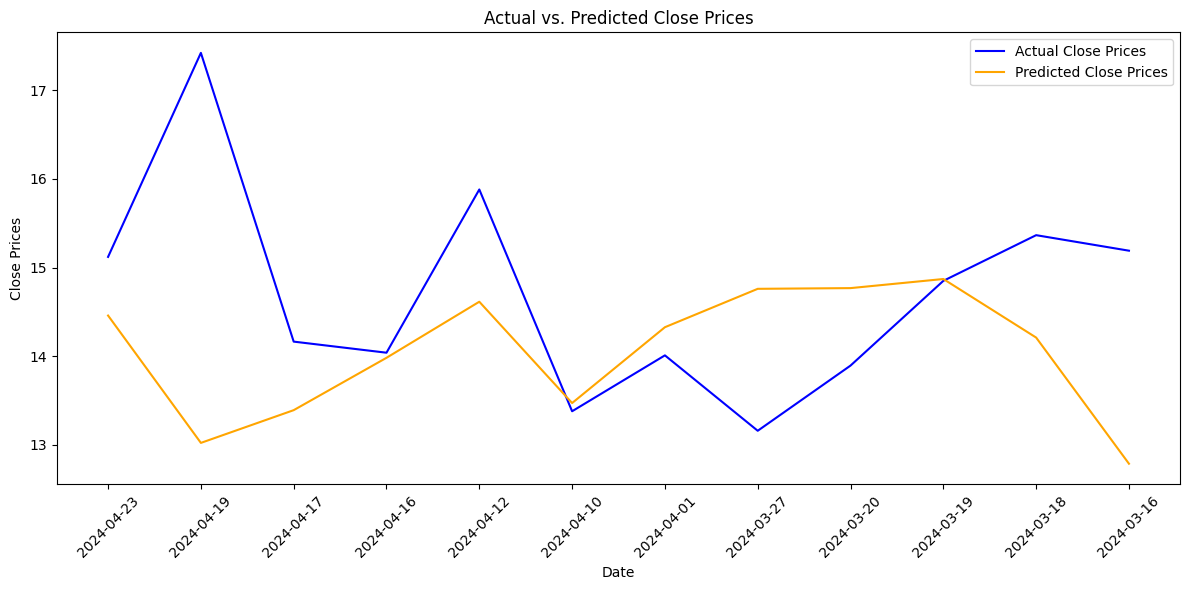

In [115]:
nltk.download('vader_lexicon')

df = pd.read_csv(csv_file)
df['headline'].fillna('', inplace=True)
df['summary'].fillna('', inplace=True)

sid = SentimentIntensityAnalyzer()
df['Headline_Sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df['Content_Sentiment'] = df['summary'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

df.to_csv('sentiment_with_scores.csv', index=False)

X = df[['Headline_Sentiment', 'Content_Sentiment']]
y = df['close_price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

test_preds = model.predict(X_test)

y_test = y_test.reset_index(drop=True)
test_preds = pd.Series(test_preds, name='Predicted')

mse_test = mean_squared_error(y_test, test_preds)
rmse_test = sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_preds)

range_close = y.max() - y.min()
mse_percentage = (mse_test / range_close) * 100
rmse_percentage = (rmse_test / range_close) * 100
mae_percentage = (mae_test / range_close) * 100

table = [['Metric', 'Error', 'Error Percentage'],
         ['MSE', mse_test, mse_percentage],
         ['RMSE', rmse_test, rmse_percentage],
         ['MAE', mae_test, mae_percentage]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, test_preds, label='Predicted Close Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()

plt.xticks(y_test.index, df.loc[y_test.index, 'date'], rotation=45)

plt.tight_layout()
plt.show()

